In this series of anomaly detection we will start by defining what is anomaly and will discuss various methods to determine an anomaly, so let's start.

What is anomaly?
An anomaly is “an observation which deviates so much from other observations 
as to arouse suspicions that it was generated by a different mechanism.” 


* Anomalies are a subset of outliers (Aggarwal 2013)
* All observations = normal data + outliers
* Outliers = noise + anomalies 
* Noise = uninteresting outliers 
* Anomaly = sufficiently interesting outlier

 A common method for scoring anomalies in 1D data is the z-score.
If the mean and standard deviation are known, then for each data point 
calculate the z-score as = data_point-mean/standard_deviation

**Let us start by analysing how z-score is calculated and can be used as anomaly detection.**

In [30]:
%matplotlib inline

import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

In [31]:
ct_test = pd.read_csv('../input/sat-ct-district-participation-2012csv/SAT_CT_District_Participation_2012.csv') 
print(ct_test.shape)
ct_test.head()

(130, 2)


,District,Participation Rate
0,Ansonia,0.66
1,Avon,0.90
2,Berlin,0.81
3,Bethel,0.86
4,Bloomfield,0.81


In [32]:
mean_rate = ct_test['Participation Rate'].mean()

# ddof is the degrees of freedom correction 
# in the calculation of the standard deviation;
# for population standard deviation ddof=0
stdev_rate = ct_test['Participation Rate'].std(ddof=0)

In [33]:
print('Mean participation rate is {:.3f}'.format(mean_rate))
print('Standard deviation is {:.3f}'.format(stdev_rate))

Mean participation rate is 0.741
Standard deviation is 0.136


Calculate the z-score and add the result to the dataframe.

In [34]:
zscore_rate = ss.zscore(ct_test['Participation Rate'], ddof=0)
ct_test = ct_test.assign(zscore=zscore_rate)
ct_test.head(8)

,District,Participation Rate,zscore
0,Ansonia,0.66,-0.593779
1,Avon,0.90,1.175649
2,Berlin,0.81,0.512113
3,Bethel,0.86,0.880744
4,Bloomfield,0.81,0.512113
5,Bolton,0.85,0.807018
6,Branford,0.77,0.217209
7,Bridgeport,0.58,-1.183589


As we are concerned about low participation rates, our cutoff will be a negative number we are looking for schools with participation rates below the mean. Here we choose $z=-2$. That is, any school with a z-score below -2 will be labeled as an anomaly. 

In [35]:
def plot_anomaly(score_data, threshold):
    
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data < threshold)
    
    
    plt.figure(dpi=150)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK schools')
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. school district', fontweight='bold')
    plt.xlabel('Ranked School district')
    plt.ylabel('Z-score')
    plt.show()

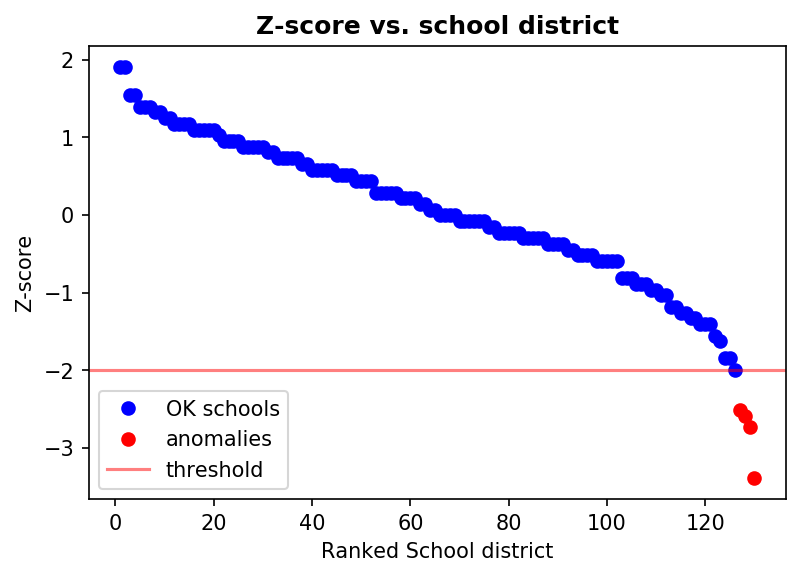

In [36]:
plot_anomaly(ct_test['zscore'], -2)

Finally, get a list of the schools that are anomalies.

In [37]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,District,Participation Rate,zscore
50,New Britain,0.40,-2.510660
99,Windham,0.37,-2.731839
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386
125,Stamford Academy,0.28,-3.395374


We have found our anomalies.

We will now look at a dataset that shows the limitations of z-scores and why the modified z-score can be useful.

We will at the number of goals scored by the top goalscorer in every World Cup from 1930 through 2018 (21 competitions in total). 

In [38]:
top_goals = pd.read_csv('../input/world-cup-top-goal-scorers/world_cup_top_goal_scorers.csv', 
                        encoding='utf-8',  
                        names=['Year', 'Player(s)', 'Goals'], skiprows=1)                                                                                
top_goals

,Year,Player(s),Goals
0,1930,Guillermo Stábile,8
1,1934,Oldřich Nejedlý,5
2,1938,Leônidas,7
3,1950,Ademir,8
4,1954,Sándor Kocsis,11
5,1958,Just Fontaine,13
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4
7,1966,Eusébio,9
8,1970,Gerd Müller,10
9,1974,Grzegorz Lato,7


In [39]:
mean_goals = top_goals['Goals'].mean()
stdev_goals = top_goals['Goals'].std(ddof=0)
print('Mean number of goals is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


In [40]:
zscore_goals = ss.zscore(top_goals['Goals'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(21)

,Year,Player(s),Goals,zscore
0,1930,Guillermo Stábile,8,0.443242
1,1934,Oldřich Nejedlý,5,-0.952971
2,1938,Leônidas,7,-0.022162
3,1950,Ademir,8,0.443242
4,1954,Sándor Kocsis,11,1.839455
5,1958,Just Fontaine,13,2.770264
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4,-1.418375
7,1966,Eusébio,9,0.908647
8,1970,Gerd Müller,10,1.374051
9,1974,Grzegorz Lato,7,-0.022162


Once again will start by using the z-score to identify anomalies. As we are interested in the superstars, this time we will have an upper threshold.  We choose $z = +2$. Above this z-score, any player will be labeled as an anomaly. 

Now, modify the previous plotting function to display the results.

In [41]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player Rank')
    plt.ylabel('Z-score')
    plt.show()

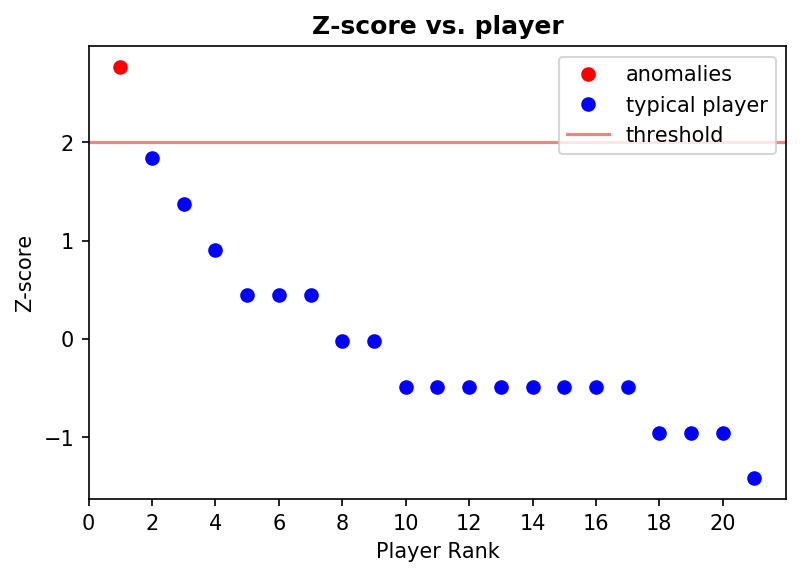

In [42]:
plot_anomaly_goals(top_goals['zscore'], 2)

In [43]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264


Only one player is picked out: Just Fontaine.

clearly our analysis is flawed. By looking at the plot, we see that in 12 out of 21 competitions, the top goalscorer(s) scored less than the mean number of goals (7.05).

So the question arises why is it so?

The answer is the mean and standard deviation are themselves susceptible to the presence of anomalies. With his 13 goals, the amazing Fontaine is raising the mean so much that most players fall below it. As a result, he becomes the only anomaly.

* let us understand this with the help of an example
* consider values = 2, 2, 3, 4, 7, 8, 9
* we have mean = 5; median = 4; mode = 2; standard-deviation = 2.725 for above values
* now we will introduce 30 an outlier:
* values = 2, 2, 3, 4, 7, 8, **30**
* now we have mean = 8; median = 4; mode = 2; standard-deviation = 9.242 for above values

And because of this the z-score can sometimes be unreliable, since the mean and standard deviation are themselves sensitive to anomalies but not median and mode.

The *modified z-score* tackles this problem by using medians instead:

In [44]:
median_goals = np.median(top_goals['Goals'])
median_goals

6.0

Now calculate the modified z-score. For each data point it is defined as $x_{i}$ as follows:

$y_{i} = (x_{i} - \tilde X)/{\rm MAD}$

where $\tilde X$ is the median of the data and MAD is the median of the absolute deviation from the median.

In [45]:
print('The value of MAD is {:.2f}'.format(mad_goals))

The value of MAD is 1.00


Here we are going to make a slight modification and introduce a consistency correction $k$, which allows us to use MAD as a consistent estimate for the standard deviation. The value of $k$ depends on the underlying distribution of the data. For simplicity, we will use the value for a normal distribution $k=1.4826$ (see [https://en.wikipedia.org/wiki/Median_absolute_deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation)).

**Note:** Correction factor of $k=1.4826$ still assumes the underlying data is normal!

So the modified z-score becomes

$y_{i} = (x_{i} - \tilde X)/(k*{\rm MAD})$

and this is the form we will use in the function below.

In [46]:
def modified_zscore(data, consistency_correction=1.4826):
    
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

As before, compute the modified z-score for all players then plot and list the results. Note that the threshold remains the same at  𝑦=+2 .

In [47]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)

In [48]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)
    
    plt.figure(dpi=150)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified z-score')
    plt.show()

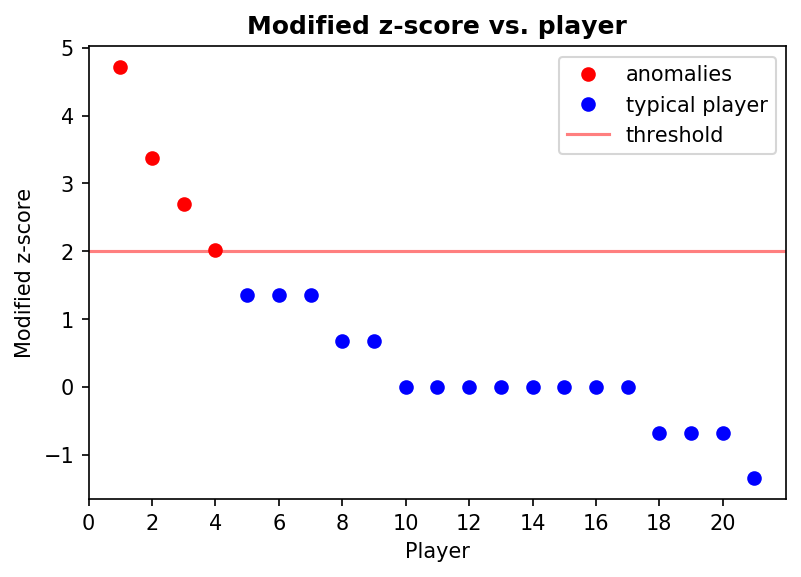

In [49]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [50]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


Now we find four anomalous players.

so this was all about anomaly detection using zscore and how modified-zscore overcomes the limitation of z-score.

* If you like this work, don't forget to upvote.
* Next time we will discuss how angle based techniques are used for anomaly detection